# Benchmarking Feedforward Network on BAF Dataset

Quick sanity-check notebook to ensure the reusable components under `src/` work nicely together on the Bank Account Fraud (BAF) dataset.

In [24]:
# Device setup
import os, torch, copy

def select_device(prefer: str | None = None) -> torch.device:
    # prefer can be: "cuda", "cuda:0", "cpu" (or None to auto)
    prefer = prefer or os.environ.get("ACCELERATOR")
    if prefer:
        prefer = prefer.lower()

    # Explicit CUDA request
    if prefer and prefer.startswith("cuda"):
        if not torch.cuda.is_available():
            print("CUDA requested but unavailable. Falling back to CPU.")
            return torch.device("cpu")
        idx = 0
        if ":" in prefer:
            _, idx_str = prefer.split(":")
            idx = int(idx_str)
        torch.cuda.set_device(idx)
        return torch.device(f"cuda:{idx}")

    # Auto-pick best available
    if torch.cuda.is_available():
        torch.cuda.set_device(0)
        return torch.device("cuda:0")
    # Optional (Apple Silicon)
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = select_device()
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"CUDA devices: {torch.cuda.device_count()}")
    print(f"Current: {torch.cuda.current_device()} - {torch.cuda.get_device_name()}")


Using device: cpu


## 1. Import BAF data

In [25]:
# ============================================================
# Load preprocessed data splits and preprocessing objects
# ============================================================
import joblib
import pandas as pd
import torch
from pathlib import Path

from src import paths

# Path setup
DATA_DIR = paths.PROCESSED_DATA_DIR  # assuming you have this imported somewhere
train_df = pd.read_parquet(DATA_DIR / "train.parquet")
val_df   = pd.read_parquet(DATA_DIR / "val.parquet")
test_df  = pd.read_parquet(DATA_DIR / "test.parquet")

# Load preprocessing artifacts (encoders + numeric pipeline)
encoders = joblib.load(DATA_DIR / "label_encoders.joblib")
num_pipeline = joblib.load(DATA_DIR / "num_pipeline.joblib")  # <- instead of scaler only

# ============================================================
# Define columns
# ============================================================
categorical_cols = ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
target_col = 'fraud_bool'

# The numeric columns after preprocessing (imputer + indicators)
num_cols = [c for c in train_df.columns if c not in categorical_cols + [target_col]]

print(f"Final numerical columns: {len(num_cols)}")
print(f"Final categorical columns: {len(categorical_cols)}")

# ============================================================
# Convert to tensors
# ============================================================
X_train_cont = torch.tensor(train_df[num_cols].values, dtype=torch.float32)
X_train_cat  = torch.tensor(train_df[categorical_cols].values, dtype=torch.long)
y_train      = torch.tensor(train_df[target_col].values, dtype=torch.float32)

X_val_cont = torch.tensor(val_df[num_cols].values, dtype=torch.float32)
X_val_cat  = torch.tensor(val_df[categorical_cols].values, dtype=torch.long)
y_val      = torch.tensor(val_df[target_col].values, dtype=torch.float32)

X_test_cont = torch.tensor(test_df[num_cols].values, dtype=torch.float32)
X_test_cat  = torch.tensor(test_df[categorical_cols].values, dtype=torch.long)
y_test      = torch.tensor(test_df[target_col].values, dtype=torch.float32)

Final numerical columns: 32
Final categorical columns: 5


In [26]:
print("# X train samples:", X_train_cont.shape[0])
print("# X val samples:", X_val_cont.shape[0])
print("# X test samples:", X_test_cont.shape[0])

# X train samples: 675666
# X val samples: 227491
# X test samples: 96843


## Embeddings for categorical features

### Helper to get the embeddings dimension

In [27]:
def pick_emb_dim(C):
    # pick one heuristic and stick to it
    # Half rule:
    return min(50, (C + 1) // 2)

### Get the cardinality and embedding dimension of each categorical feature

In [28]:
print("Categorical columns:", categorical_cols)
print("Encoder classes:    ", encoders.keys())
cardinality = []
emb_dims = []
for index, col in enumerate(categorical_cols):
    print(f"{col}: {len(encoders[col].classes_)}")
    cardinality.append(len(encoders[col].classes_))
    emb_dims.append(pick_emb_dim(len(encoders[col].classes_)))
    
print("Cardinality:         ", cardinality)
print("Embedding dimensions:", emb_dims)


Categorical columns: ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
Encoder classes:     dict_keys(['device_os', 'employment_status', 'housing_status', 'payment_type', 'source'])
device_os: 5
employment_status: 7
housing_status: 7
payment_type: 5
source: 2
Cardinality:          [5, 7, 7, 5, 2]
Embedding dimensions: [3, 4, 4, 3, 1]


### Define the embeddings layer

In [29]:
import torch
import torch.nn as nn
from typing import Sequence, List, Optional

class EmbeddingStack(nn.Module):
    """
    Holds one nn.Embedding per categorical feature.
    This module ONLY performs lookups and returns the per-feature embeddings.
    """
    def __init__(self, cardinals: Sequence[int], emb_dims: Sequence[int]):
        super().__init__()
        assert len(cardinals) == len(emb_dims), "cardinals and emb_dims must align"
        # No UNK now → no padding_idx
        self.embs = nn.ModuleList([nn.Embedding(C, d) for C, d in zip(cardinals, emb_dims)])
        self.output_dims = list(emb_dims)
        # Each nn.Embedding holds a trainable weight matrix [num_categories, emb_dim].
        # Gradients flow through the lookup; AdamW (below) updates these per batch.
        # No padding_idx here; all IDs are assumed valid from label encoding.

        # (Later, with UNK: nn.Embedding(C, d, padding_idx=0))
    
    def forward(self, x_cats: torch.LongTensor) -> List[torch.Tensor]:
        """
        x_cats: [B, n_cats] with IDs in [0..C_i-1] per column i.
        returns: list of tensors [B, d_i] (one per categorical feature).
        """
        return [emb(x_cats[:, i]) for i, emb in enumerate(self.embs)]


### Get the embeddings per feature

In [30]:
# Instantiate embeddings; their weight matrices will receive gradients
# from the loss and be updated by AdamW during training.
emb_stack = EmbeddingStack(cardinality, emb_dims)

print(emb_stack)


EmbeddingStack(
  (embs): ModuleList(
    (0): Embedding(5, 3)
    (1-2): 2 x Embedding(7, 4)
    (3): Embedding(5, 3)
    (4): Embedding(2, 1)
  )
)


In [31]:
X_train_emb = emb_stack(X_train_cat)  # List[Tensor[B, d_i]]
X_val_emb   = emb_stack(X_val_cat)

X_train_emb[4].shape

torch.Size([675666, 1])

### Concatenate embeddings and numerical features

In [32]:
def concat_cat_and_num(emb_list: List[torch.Tensor],
                       x_nums: Optional[torch.Tensor]) -> torch.Tensor:
    """
    Concatenate cat embeddings and numeric features along feature dim.
    emb_list: list of [B, d_i]
    x_nums:   [B, n_num] or None
    returns:  [B, sum(d_i) + n_num]
    """
    parts = []
    if emb_list:
        parts.append(torch.cat(emb_list, dim=1))
    if x_nums is not None and x_nums.numel() > 0:
        parts.append(x_nums)
    assert parts, "No features to concatenate."
    return torch.cat(parts, dim=1)

In [33]:
X_train_all = concat_cat_and_num(X_train_emb, X_train_cont)
X_train_all.shape

torch.Size([675666, 47])

### Compute the sample feature dimension (for the FFN input)

In [34]:
input_dim = sum(emb_dims) + X_train_cont.shape[1]
print("Computed input_dim (sum embeddings + numericals) =", input_dim)
# Good to sanity-check: x_all_b.shape[1] should equal input_dim
assert X_train_all.shape[1] == input_dim

Computed input_dim (sum embeddings + numericals) = 47


In [35]:
X_train_all[0, :]

tensor([-1.0353e+00, -1.0354e+00,  5.3393e-01,  4.3436e-01,  2.1974e-01,
         1.6391e+00,  7.2293e-01,  4.3180e-01,  8.9319e-01,  1.2638e+00,
        -1.8421e-01,  5.7202e-01,  4.6947e-01,  9.7394e-01,  1.0463e+00,
         2.5000e-01,  9.8651e-01,  7.2581e-02,  5.8824e-02,  3.7500e-01,
         8.7951e-05,  9.0702e-01,  1.5793e-01,  7.8346e-01,  7.9632e-01,
         9.3713e-01,  2.1000e-03,  1.2821e-01,  4.1902e-01,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  2.5806e-01,  0.0000e+00,  6.8586e-01,
         0.0000e+00,  1.8885e-01,  1.0000e+00,  5.0000e-01,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], grad_fn=<SliceBackward0>)

## Train the FFN model

### Imports & run config (batching, steps/epoch, etc.)

In [36]:
# Core
import sys, math, itertools
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, BatchSampler

# Project bits
# (ensure the path that contains ffn.py / metrics.py is on sys.path if needed)
# sys.path.append("/mnt/data")  # uncomment if imports fail

from src.models.ffn import FeedforwardNetwork          # residual-capable MLP
from src.training.metrics import (                       # WBCE + metrics
    weighted_bce_with_logits,
    logits_to_preds, precision, recall, recall_at_FPR
)

# ---- Run config ----
BATCH_SIZE = 512
POS_FRAC   = 0.01                      # ~1% frauds per batch
POS_PER_B  = max(1, int(round(BATCH_SIZE * POS_FRAC)))  # ≈5
# Note: LR schedulers step per-batch; total steps = STEPS_PER_EPOCH * NUM_EPOCHS.
STEPS_PER_EPOCH = 1000                 # ~1000 batches per epoch
NUM_EPOCHS = 5                         # choose; change as you like


print({
    "batch_size": BATCH_SIZE,
    "pos_per_batch": POS_PER_B,
    "steps_per_epoch": STEPS_PER_EPOCH,
    "epochs": NUM_EPOCHS,
    "device": str(device)
})


{'batch_size': 512, 'pos_per_batch': 5, 'steps_per_epoch': 1000, 'epochs': 5, 'device': 'cpu'}


### Build the 3-layer FFN with different dropouts and pre1 → post2 residual

In [37]:
# Assumptions from your previous cells:
# - emb_stack : EmbeddingStack(...) already created
# - emb_dims  : list[int] per categorical feature
# - n_num     : number of numeric features
# - A concat function: concat_cat_and_num(emb_list, x_nums) -> [B, D]
# - Your dataloaders yield (x_cats, x_nums, y) OR you have a Dataset to do that.

# Compute input dimension (sum of embedding dims + numeric)
print("input_dim =", input_dim)

# Define 3 hidden layers and per-layer dropouts
hidden_layers = [
    {"units": 256, "activation": "relu", "dropout": 0.20}, 
    {"units": 128, "activation": "relu", "dropout": 0.30}, #NOTE: use dropout with residual is correct?????
    {"units":  64, "activation": "relu", "dropout": 0.15},
]

# One residual: pre1 -> post2 (i.e., before layer 1 → after layer 2)
# Residual spec: takes tensor just before layer 1 and adds it to the
# output after layer 2 (pre1 -> post2), improving gradient flow.
residuals = [
    {"from": ("pre", 1), "to": ("post", 2)}
]

ffn = FeedforwardNetwork(
    n_classes=1,                 # binary head (BCEWithLogits)
    n_features=input_dim,
    hidden_layers=hidden_layers,
    residual_specs=residuals,
)
# Move both models to the selected device to avoid device mismatch errors
# Ensure both modules live on the same device as the data.
# Their parameters receive gradients and updates on this device.
emb_stack = emb_stack.to(device)
ffn = ffn.to(device)

print(ffn)


input_dim = 47
FeedforwardNetwork(
  (hidden_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=47, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.15, inplace=False)
    )
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (_skip_projs): ModuleDict(
    (proj_0): Linear(in_features=47, out_features=128, bias=False)
  )
)


### Loss: Weighted BCE (WBCE)

In [38]:
# With ~1% positives per batch, an unbiased WBCE uses pos_weight ~= (1-p)/p = 99.
# NOTE: If you later change the batch composition (oversampling etc.),
# revisit this value accordingly.
POS_WEIGHT = 99.0
# pos_weight scales positive examples inside BCEWithLogits;
# gradients for positive samples are amplified by POS_WEIGHT.

loss_fn = weighted_bce_with_logits(pos_weight=POS_WEIGHT)  # from metrics.py
print(loss_fn)


BCEWithLogitsLoss()


### Optimizers (AdamW for embeddings + output; SGD for the rest) and Schedulers

In [39]:
# Separate parameters by group:
def param_set(params):
    return {id(p) for p in params}

# Embedding params
# Embedding matrices (one per categorical feature)
emb_params = list(itertools.chain.from_iterable(e.parameters() for e in emb_stack.embs))
# Output layer params (last layer)
# Output/classification head parameters
out_params = list(ffn.output_layer.parameters())

# Hidden layers params (all except output)
# Hidden MLP layers parameters (all but output)
hidden_params = list(itertools.chain.from_iterable(layer.parameters() for layer in ffn.hidden_layers))

# Build disjoint groups: AdamW (embeddings + output), SGD (hidden)
# Optimized by AdamW: embeddings + output layer
adamw_params = emb_params + out_params
# Optimized by SGD: hidden layers only
sgd_params   = hidden_params

# Safety assertion: no parameter should be in both groups
assert param_set(adamw_params).isdisjoint(param_set(sgd_params)), "Param groups overlap!"

# --- Optimizers ---
opt_adamw = torch.optim.AdamW(adamw_params, lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-2)
opt_sgd   = torch.optim.SGD(sgd_params, lr=5e-3, momentum=0.9, nesterov=True)

# --- Schedulers ---
# We'll step per *batch*. Cosine for AdamW across the total number of steps; StepLR for SGD (decay ~once per epoch).
# Note: LR schedulers step per-batch; total steps = STEPS_PER_EPOCH * NUM_EPOCHS.
TOTAL_STEPS = STEPS_PER_EPOCH * NUM_EPOCHS

sched_adamw = torch.optim.lr_scheduler.CosineAnnealingLR(opt_adamw, T_max=TOTAL_STEPS)
sched_sgd   = torch.optim.lr_scheduler.StepLR(opt_sgd, step_size=STEPS_PER_EPOCH, gamma=0.9)

def zero_grads():
    # Reset accumulated gradients for both optimizers/groups
    opt_adamw.zero_grad(set_to_none=True)
    opt_sgd.zero_grad(set_to_none=True)

def step_optimizers_and_schedulers():
    # Apply parameter updates
    # - AdamW updates embedding matrices and output head weights
    # - SGD updates hidden MLP weights
    opt_adamw.step()
    opt_sgd.step()
    # Per-batch LR scheduling for both optimizers
    sched_adamw.step()
    sched_sgd.step()

print("AdamW groups:", len(opt_adamw.param_groups), " | SGD groups:", len(opt_sgd.param_groups))


AdamW groups: 1  | SGD groups: 1


### Stratified batch sampler (~1% positives per batch, 512 total), ~1000 batches/epoch

In [40]:
import numpy as np
from torch.utils.data import Sampler

class StratifiedBatchSampler(Sampler):
    """
    Yields index lists of length `batch_size`, with approximately `pos_per_batch` positives
    and the rest negatives, for exactly `num_batches` batches per epoch (with replacement).
    """
    def __init__(self, y: np.ndarray, batch_size: int, pos_per_batch: int, num_batches: int):
        assert batch_size > 0 and pos_per_batch >= 0
        assert pos_per_batch <= batch_size
        self.y = (y.astype(int)).ravel()
        self.batch_size = batch_size
        self.pos_per_batch = pos_per_batch
        self.neg_per_batch = batch_size - pos_per_batch
        self.num_batches = num_batches

        self.pos_idx = np.flatnonzero(self.y == 1)
        self.neg_idx = np.flatnonzero(self.y == 0)
        if len(self.pos_idx) == 0 or len(self.neg_idx) == 0:
            raise ValueError("Labels must contain both positive (1) and negative (0) examples.")

    def __len__(self):
        return self.num_batches

    def __iter__(self):
        # Build class-balanced batches via sampling with replacement
        # Ensures ~pos_per_batch positives per batch across num_batches.
        # sample with replacement to avoid exhaustion
        rng = np.random.default_rng()
        for _ in range(self.num_batches):
            pos = rng.choice(self.pos_idx, size=self.pos_per_batch, replace=True)
            neg = rng.choice(self.neg_idx, size=self.neg_per_batch, replace=True)
            idx = np.concatenate([pos, neg])
            rng.shuffle(idx)
            yield idx.tolist()


In [41]:
import torch
from torch.utils.data import Dataset, DataLoader

class CatsNumsDataset(Dataset):
    def __init__(self, X_cats, X_nums, y):
        self.x_cats = torch.as_tensor(X_cats, dtype=torch.long)      # for embeddings
        self.x_nums = torch.as_tensor(X_nums, dtype=torch.float32)   # numeric
        self.y      = torch.as_tensor(y, dtype=torch.long)           # labels {0,1}
        # Labels are stored as long here but cast to float in the
        # training loop for BCEWithLogits loss.

        assert self.x_cats.shape[0] == self.x_nums.shape[0] == self.y.shape[0]

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, i):
        return self.x_cats[i], self.x_nums[i], self.y[i]


In [42]:
# Assume: Xc_train, Xn_train, y_train, Xc_val, Xn_val, y_val already exist
train_ds = CatsNumsDataset(X_train_cat, X_train_cont, y_train)
val_ds   = CatsNumsDataset(X_val_cat,   X_val_cont,   y_val)

# Reuse the sampler we set up earlier (≈1% positives, 512 batch, ~1000 batches/epoch)
import numpy as np
y_train_np = np.asarray(y_train)
train_sampler = StratifiedBatchSampler(y_train_np, batch_size=512, pos_per_batch=max(1, int(0.01*512)), num_batches=1000)

# Use custom batch_sampler for balanced class batches on train;
# pin_memory speeds host->device transfers on CUDA; num_workers for parallel loading.
train_loader = DataLoader(train_ds, batch_sampler=train_sampler, pin_memory=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=1024, shuffle=False, pin_memory=True, num_workers=2)


### Train/Val loops (two optimizers; metrics = recall & precision)

In [43]:

@torch.no_grad()
# Inference mode: no gradients tracked and no parameter updates.
def evaluate_epoch(emb_stack, ffn, loader, device,FPR=0.1):
    # eval(): disable dropout/BN updates for deterministic evaluation
    ffn.eval()
    emb_stack.eval()
    all_preds, all_targets = [], []
    total_loss, total_n = 0.0, 0

    for x_cats, x_nums, y in loader:
        x_cats = x_cats.to(device).long()
        x_nums = x_nums.to(device).float()
        y      = y.to(device).float().view(-1)

        emb_list = emb_stack(x_cats)
        x_all    = concat_cat_and_num(emb_list, x_nums)
        logits   = ffn(x_all).squeeze(1)

        loss = loss_fn(logits, y)
        total_loss += float(loss.item()) * y.size(0)
        total_n    += y.size(0)

        preds, _ = logits_to_preds(logits, task="binary")
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu().long())

    if total_n == 0:
        return {"loss": float("nan"), "recall": 0.0, "precision": 0.0}

    preds_cat   = torch.cat(all_preds)
    targets_cat = torch.cat(all_targets)
    return {
        "loss": total_loss / total_n,
        "recall": recall(preds_cat, targets_cat),
        "precision": precision(preds_cat, targets_cat),
        "recall@FPR": recall_at_FPR(preds_cat, targets_cat, fpr_target=FPR)
    }


def train_epoch(emb_stack, ffn, loader, device, log_every=100):
    # train(): enable dropout and other train-time layers
    # emb_stack and ffn will accumulate grads from loss.backward()
    ffn.train()
    emb_stack.train()
    running_loss, seen = 0.0, 0
    last_log = 0

    for step, (x_cats, x_nums, y) in enumerate(loader, start=1):
        x_cats = x_cats.to(device).long()
        x_nums = x_nums.to(device).float()
        y      = y.to(device).float().view(-1)

        # forward
        # Embedding lookups produce dense vectors; these receive gradients via backprop.
        emb_list = emb_stack(x_cats)
        x_all    = concat_cat_and_num(emb_list, x_nums)
        logits   = ffn(x_all).squeeze(1)
        loss     = loss_fn(logits, y)

        # backward (two optimizers)
        # 1) Zero grads on both optimizers
        # 2) Backprop to compute grads for embeddings + all FFN params
        # 3) Step optimizers to update weights; step schedulers to adjust LRs
        zero_grads()
        loss.backward()
        step_optimizers_and_schedulers()

        # stats
        bs = y.size(0)
        running_loss += float(loss.item()) * bs
        seen += bs

        if log_every and (step % log_every == 0):
            avg = running_loss / max(seen, 1)
            lrs = [g['lr'] for g in opt_adamw.param_groups] + [g['lr'] for g in opt_sgd.param_groups]
            print(f"[step {step}] loss={avg:.4f}  lrs(min/max)=({min(lrs):.2e}/{max(lrs):.2e})")
            last_log = step

        if step >= STEPS_PER_EPOCH:
            break

    return {"loss": running_loss / max(seen, 1)}


### Run 

In [ ]:
from collections import defaultdict
history = defaultdict(list)
tolerance = 10
no_improve_epochs = 0
best_recall_fpr = -float("inf")
best_epoch = 0
best_model_state = None  # will store the best model weights in memory

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n=== Epoch {epoch}/{NUM_EPOCHS} ===")
    train_stats = train_epoch(emb_stack, ffn, train_loader, device, log_every=200)
    val_stats   = evaluate_epoch(emb_stack, ffn, val_loader, device)

    history["train_loss"].append(train_stats["loss"])
    history["val_loss"].append(val_stats["loss"])
    history["val_recall"].append(val_stats["recall"])
    history["val_precision"].append(val_stats["precision"])
    history["val_recall@FPR"].append(val_stats["recall@FPR"])

    current_recall_fpr = val_stats["recall@FPR"]

    print(f"train_loss={train_stats['loss']:.4f} | "
          f"val_loss={val_stats['loss']:.4f} | "
          f"val_recall={val_stats['recall']:.4f} | "
          f"val_precision={val_stats['precision']:.4f} | "
          f"val_recall@FPR={current_recall_fpr:.4f}")

    # --- Early stopping check ---
    if current_recall_fpr > best_recall_fpr+1e-4:  # significant improvement NOTE: should we use this value??
        best_recall_fpr = current_recall_fpr
        best_epoch = epoch
        no_improve_epochs = 0

        # Save best model in memory
        best_model_state = copy.deepcopy(ffn.state_dict())
        print(f"New best recall@FPR={best_recall_fpr:.4f} — model stored in memory.")

    else:
        no_improve_epochs += 1
        print(f"No improvement for {no_improve_epochs}/{tolerance} epochs.")

    if no_improve_epochs >= tolerance:
        print(f"\nEarly stopping triggered after {tolerance} epochs without improvement.")
        print(f"Best model was from epoch {best_epoch} with recall@FPR={best_recall_fpr:.4f}")
        break

NameError: name 'defaultdict' is not defined

### Plots: Loss, ROC, and Precision/Recall@k

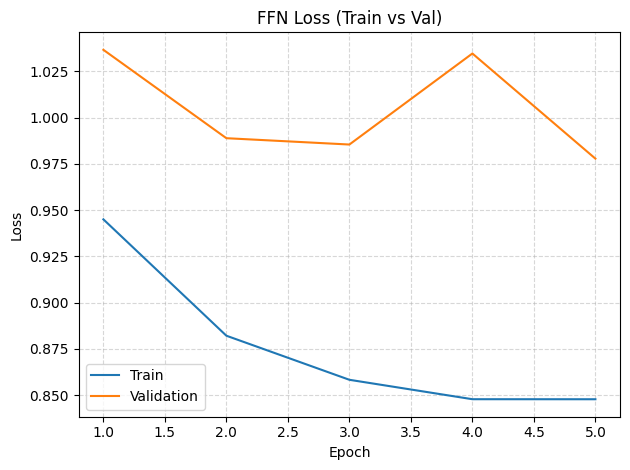

In [ ]:
# Plot train/val loss curves
from src.viz.plots import plot_loss
fig_loss = plot_loss(history, title="FFN Loss (Train vs Val)")

In [ ]:
# quick plot of the recall@FPR curve
import matplotlib.pyplot as plt

plt.plot(history["val_recall@FPR"], marker='o')

In [ ]:
# Collect validation labels and scores (logits) for ROC and @k plots
import torch
ffn.eval(); emb_stack.eval()
y_true, y_scores = [], []
with torch.no_grad():
    for x_cats, x_nums, y in val_loader:
        x_cats = x_cats.to(device).long()
        x_nums = x_nums.to(device).float()
        logits = ffn(concat_cat_and_num(emb_stack(x_cats), x_nums)).squeeze(1)
        y_scores.append(logits.detach().cpu())
        y_true.append(y.view(-1).cpu().long())
y_true = torch.cat(y_true)
y_scores = torch.cat(y_scores)
y_true.shape, y_scores.shape

(torch.Size([227491]), torch.Size([227491]))

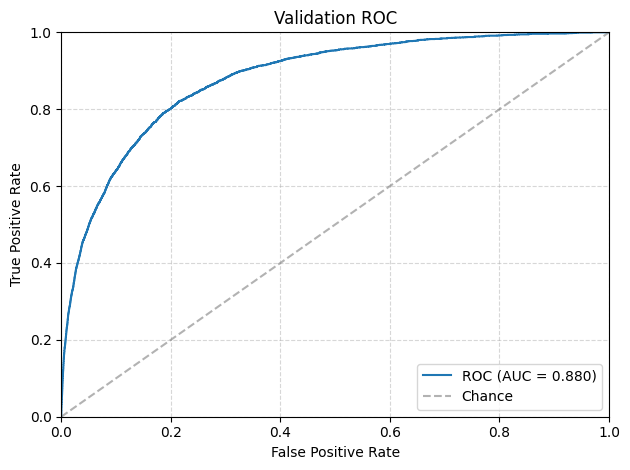

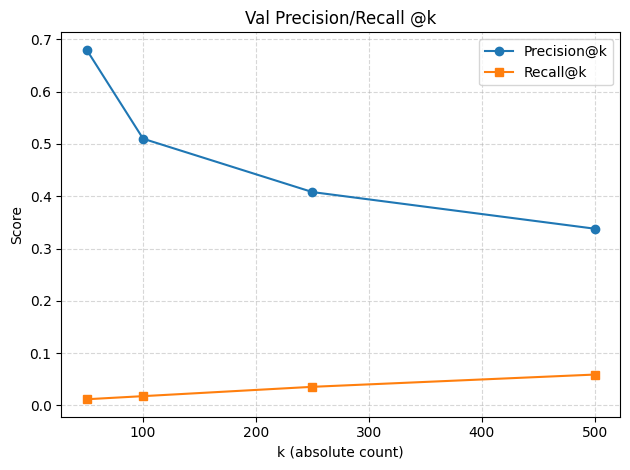

In [ ]:
# Plot ROC and Precision/Recall@k
from IPython.display import display
from src.viz.plots import plot_roc_from_scores, plot_precision_recall_k

fig_roc = plot_roc_from_scores(y_true, y_scores, from_logits=True, title="Validation ROC")


# Choose k as absolute counts or fractions in (0,1]
ks = [50, 100, 250, 500]  # e.g., top-50/100/250/500
fig_k = plot_precision_recall_k(y_true, y_scores, ks, from_logits=True, title="Val Precision/Recall @k")